In [27]:
#
# Simulate an R9 run on nanopore
# The run is <24 hours
#
import pymc3 as pm
import numpy as np
import theano.tensor as T

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from functools import partial

In [5]:
datatypes = [
    ('total_num_reads', np.int),        ('total_dna_read', np.int),
    ('num_minutes', np.float),
    ('num_active_pores_start', np.int), ('num_active_pores_end', np.int),
    ('mean_input_dna_len', np.float)]

# Currently:
# - read all DNA loaded (no dna breaking model)
# - one pore only that gets used up during the run
#
data = np.array([
  (  52,  2000*52,     60.0,    1,    1,  2000.0),
  (  52,  2000*52,     60.0,    1,    1,  2000.0),
  (  47,  4000*47,     60.0,    1,    1,  4000.0),
  (  94,  4000*94,    120.0,    1,    1,  4000.0),

  ( 100, 4000*100,    240.0,    1,    0,  4000.0),
  ( 150, 4000*150,    240.0,    1,    0,  4000.0),
  (  75,  4000*75,    240.0,    1,    0,  4000.0),
  ( 175, 4000*175,    240.0,    1,    0,  4000.0),
  ( 175, 4000*175,    480.0,    1,    0,  4000.0),
], dtype=datatypes)

#data = np.array([
#   (  44,    69501,     60.0,    1,    1,  2000.0),
#   (  36,   275440,     60.0,    1,    1,  8000.0),
#   (  51,   127152,     60.0,    1,    1,  3000.0),
#   (  59,   161172,     60.0,    1,    1,  3000.0),
#   (  75,   582726,    120.0,    1,    1,  8000.0),
#   ( 134,   938406,    180.0,    1,    1,  8000.0),
#   ( 156,   312548,    180.0,    1,    1,  2000.0),
#   ( 167,   334427,    300.0,    1,    0,  2000.0),
#   ( 316,   587468,    600.0,    1,    0,  2000.0),
#   ( 344,  1046926,    600.0,    1,    0,  3000.0),
#   ( 470,  1534980,    600.0,    1,    1,  3000.0),
#   ( 319,   643649,   3000.0,    1,    0,  2000.0),
#   ( 285,   862323,   3000.0,    1,    0,  3000.0),
#   ( 932,  2851522,   3000.0,    1,    0,  3000.0),
#   (1107,  2215908,   3000.0,    1,    0,  2000.0),
#   (1134,  3361498,   3000.0,    1,    0,  3000.0),
#   (2044,  6054852,   3000.0,    1,    0,  3000.0),
#   (2051,  4024988,   3000.0,    1,    0,  2000.0),
#   (2195, 10884337,   3000.0,    1,    1,  5000.0),
#], dtype=datatypes)

In [ ]:
def test_Lognormal():
    """How does the Lognormal tau parameter map onto sd?"""
    nd = np.random.normal(loc=1000, scale=10, size=1000)
    print(np.mean(nd), np.std(nd))
    shape0,loc0,scale0 = st.lognorm.fit(nd, 1, floc=0)
    print(shape0, loc0, scale0)

    with pm.Model() as model:
        sd = 10
        input_dna_len = pm.Lognormal('test', mu=np.log(100000), tau=1)
        gam = pm.Gamma('gam', 10, 10)
        start = pm.find_MAP()
        print("start", start)
        step = pm.Metropolis()
        trace = pm.sample(1000, step, start=start)
        print(np.mean(trace['test']), np.std(trace['test']))
        print(np.mean(trace['gam']), np.std(trace['gam']))
        print(shape0, loc0, scale0, np.log(1000), 100)


def test_DensityDist():
    """How to use DensityDist to enforce a constraint"""
    import scipy.stats as sp
    from functools import partial

    def apply_mul_constraint(f1, f2, observed):
        # pm.log = <T.elemwise.Elemwise>
        diff = T.sub(T.mul(f1, f2), observed)
        # This works up to a point
        # like = -pm.log(T.sqr(diff))
        # This "normal" version just fails?
        # like = pm.log(T.exp(T.neg(T.sqr(diff))))
        # This is the most robust way to do it, allowing for unlikely f1/f2?
        like = -T.abs_(diff)

        print("values", len(list(observed)), observed, like)
        return like

    with pm.Model() as model:
        dd_data = np.repeat(1000,5) #np.random.normal(loc=250, scale=10, size=10)
        norm1 = pm.Normal('norm1', mu=10, sd=1)
        norm2 = pm.Normal('norm2', mu=20, sd=2)

        norm_constraint = partial(apply_mul_constraint, norm1, norm2)
        constraint = pm.DensityDist('constraint', norm_constraint, observed=dd_data)

        step = pm.Metropolis() # or NUTS
        trace = pm.sample(1000, step)
        print("mean", len(trace['norm1']), np.mean(trace['norm1']),
            len(trace['norm2']), np.mean(trace['norm2']))
        print(trace['norm1'][10:15], trace['norm1'][-5:])
        print(trace['norm2'][10:15], trace['norm2'][-5:])
        print(trace['norm1'][-1] * trace['norm2'][-1])

        f = plt.figure()
        ax = pm.traceplot(trace[-1000:],
                          figsize=(12,len(trace.varnames)*1.5),
                          lines={k: v['mean'] for k, v in pm.df_summary(trace[-1000:]).iterrows()})

        plt.savefig("temp.png")


#test_Lognormal()
#test_DensityDist()

How to use Deterministic observations
(https://groups.google.com/forum/#!topic/pymc/gAImsliT34o)

    say you have two random variables with known priors
    X ~ f(theta_1)
    Y ~ g(theta_2)
    and you observe only the sum of the two, Z = X + Y.
    This is a case when you would like to have an observed deterministic.
    you can try to write Z as a stochastic but it could be very difficult, especially if Z is depend on more then two parameters.
    You cannot separately estimate theta_1 and theta_2 with only the sum to inform them, but if I were to build a model of this in PyMC, this is how I would approach it:
    theta_1 = Uniform('theta_1', 0, 100, value=2)
    theta_2 = Uniform('theta_2', 0, 100, value=2)
    x = Poisson('x', theta_1)
    y = Lambda('y', lambda x=x: z-x)
    @potential
    def ydist(y=y, theta=theta_2):
        return poisson_like(y, theta)
    So, the factor potential essentially constrains the resulting y values to be distributed according to a Poisson with parameter theta_2.

In [33]:
def apply_mul_constraint(f1, f2, observed):
    return -T.abs_(T.sub(T.mul(f1, f2), observed))

def apply_min_constraint(f1, f2, observed):
    """Use the closest of f1 and f2 to the observed values as the likelihood.
    T.min and T.minimum are not the same!"""
    return -T.abs_(T.sub(T.minimum(f1, f2), observed))

USE_ADVI = True

with pm.Model() as model:
    #
    # Inputs to the model
    #

    num_seconds_run = data['num_minutes'] * 60
    num_active_pores_start = data['num_active_pores_start']
    mean_input_dna_len = data['mean_input_dna_len']

    #
    # Priors
    #
    Truncated0Normal = pm.Bound(pm.Normal, lower=0)

    # The input DNA is sheared somehow, or should have a mostly known size distribution.
    # Why lognormal? A DNA break halves the size of a segment, so closer to multiplicative than additive.
    # The data we've seen has long tail and looks lognormal
    # tau = 10 corresponds to sd=30% of dna length, (tau=5=50%, tau=100=10%, tau=1=100%)
    prior_input_dna_len_tau = 10
    input_dna_len = pm.Lognormal('input_dna_len', mu=np.log(mean_input_dna_len), tau=prior_input_dna_len_tau,
                                 testval=mean_input_dna_len, shape=(len(data),))

    # How long does one pore wait to capture a segment of DNA?
    # "Exponential describes the time between events in a Poisson process"
    # http://www.wolframalpha.com/input/?i=exponential(rate%3D1%2F50.)
    prior_mean_time_to_capture_dna = 60
    time_to_capture_dna = pm.Exponential('time_to_capture_dna', lam=1./prior_mean_time_to_capture_dna)

    # after a read finishes pores should rarely be blocked
    # a prior of 1% seems reasonable
    prior_p_pore_blocked_a, prior_p_pore_blocked_b, = 1, 1
    p_pore_blocked = pm.Beta('p_pore_blocked', alpha=prior_p_pore_blocked_a, beta=prior_p_pore_blocked_b)


    # I expect read speed to be between 200 and 300 (2 SDs)
    # I assume read_speed is due to some property of the chip (voltage) and doesn't change over time
    prior_mean_read_speed, prior_sd_read_speed = 250, 25 # bases/s
    read_speed = Truncated0Normal('read_speed', mu=prior_mean_read_speed, sd=prior_sd_read_speed)

    # The time to read DNA is easily calculated
    time_to_read_dna = pm.Deterministic('time_to_read_dna', T.true_div(input_dna_len, read_speed))


    # Per pore, how many reads can I do before getting blocked?
    # This obeys a geometric distribution
    if USE_ADVI:
        num_reads_before_blockage = pm.Exponential('num_reads_before_blockage', lam=p_pore_blocked)
    else:
        num_reads_before_blockage = pm.Geometric('num_reads_before_blockage', p=p_pore_blocked)

    # A read means waiting for DNA, then sequencing it
    num_reads_possible_in_time = pm.Deterministic('num_reads_possible_in_time',
        T.true_div(num_seconds_run, T.add(time_to_capture_dna, time_to_read_dna)))


    # How many pores are left at the end? (Currently, 1 or 0)
    # This is a function of p_pore_blocked and
    # total_reads -- at time 0, 0 pores are blocked, at time inf, all are blocked
    num_active_pores_end = data['num_active_pores_end']

    # You can read until you get blocked
    # min fails for some unknown reason
    total_num_reads_constraint = partial(apply_min_constraint, num_reads_before_blockage, num_reads_possible_in_time)
    total_num_reads = pm.DensityDist('total_num_reads', total_num_reads_constraint,
                                     observed=data['total_num_reads'])

    #
    # Outputs
    #

    # Total DNA read is input_dna_len * total_num_reads
    total_dna_read_constraint = partial(apply_mul_constraint, input_dna_len, total_num_reads)
    total_dna_read = pm.DensityDist('total_dna_read', total_dna_read_constraint,
                                    observed = data['total_dna_read'])


    #
    # Print and plot
    #
    # Then number of reads is the final output
    N = 5000

    if USE_ADVI:
        v_params = pm.variational.advi(n=100000)
        trace = pm.variational.sample_vp(v_params, draws=N)
    else:
        step = pm.Metropolis()
        trace = pm.sample(N, step, njobs=12)

    #print(trace.varnames)
    #for var in sorted(v for v in trace.varnames if not v.endswith('_')):
    #    print(var, trace[var][:5], trace[var][-5:])

    print(pm.df_summary(trace[-N//2:]))

Applied log-transform to input_dna_len and added transformed input_dna_len_log_ to model.
Applied log-transform to time_to_capture_dna and added transformed time_to_capture_dna_log_ to model.
Applied logodds-transform to p_pore_blocked and added transformed p_pore_blocked_logodds_ to model.
Applied lowerbound-transform to read_speed and added transformed read_speed_lowerbound_ to model.
Applied log-transform to num_reads_before_blockage and added transformed num_reads_before_blockage_log_ to model.
Iteration 0 [0%]: ELBO = -2683797.9
Iteration 10000 [10%]: Average ELBO = -1257297.93
Iteration 20000 [20%]: Average ELBO = -122240.39
Iteration 30000 [30%]: Average ELBO = -10405.42
Iteration 40000 [40%]: Average ELBO = -1591.39
Iteration 50000 [50%]: Average ELBO = -902.97
Iteration 60000 [60%]: Average ELBO = -845.63
Iteration 70000 [70%]: Average ELBO = -832.97
Iteration 80000 [80%]: Average ELBO = -830.87
Iteration 90000 [90%]: Average ELBO = -829.72
Finished [100%]: Average ELBO = -827

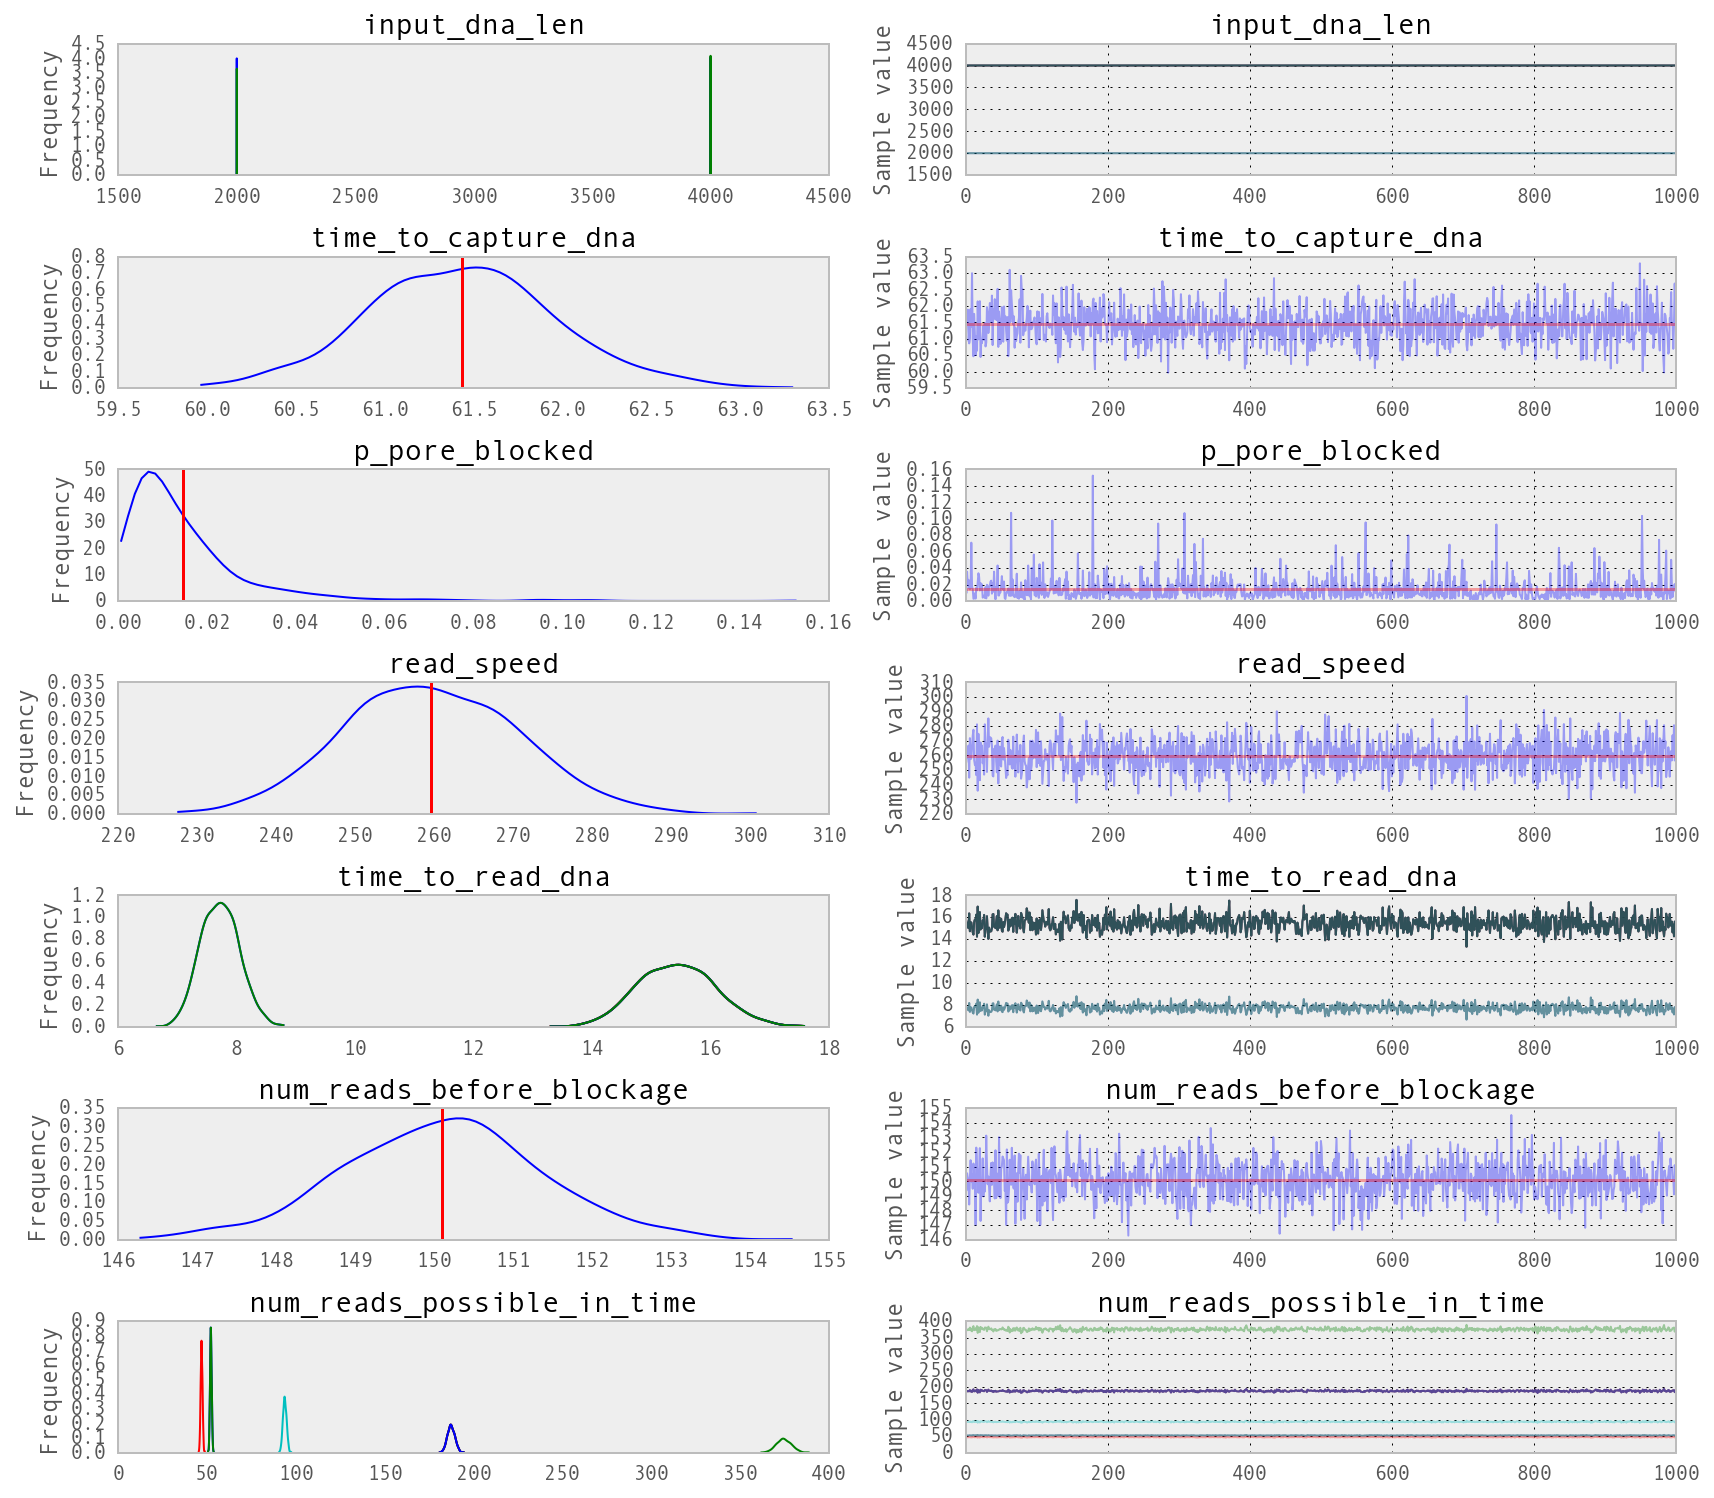

In [35]:
with pm.Model() as model:
    # Plotting is very slow for some reason
    pm.traceplot(trace[-1000:], 
                 #varnames=['time_to_capture_dna', 'p_pore_blocked', 'read_speed','num_reads_before_blockage'],
                 figsize=(12,len(trace.varnames)*1.5),
                 lines={k: v['mean'] for k, v in pm.df_summary(trace[-1000:]).iterrows()})